<h1>FlowSOM Clustering</h1>

We've seen previously the application of supervised machine learning with the `CellClassifier` to generate `Population`'s but another approach is high dimensional clustering, popularised in cytometry bioinformatics by algorithms such as FlowSOM, Phenograph, VShift and SPADE (to name a few). 

In CytoPy, we have the `Clustering` class that facilitates high dimensional clustering whilst generating `Population` data structures that can be integrated with the rest of the framework and persist in our database for comparison of methods.

In this notebook we will introduce the `Clustering` class using FlowSOM as an example. The `Clustering` class loads the events data of every `FileGroup` in an `Experiment` into it's `data` attribute and then allows both clustering of individual `FileGroup`'s (biological samples that we will refer to hereon in as 'samples') and meta clustering that clusters the clusters between samples.

The `Clustering` class is in fact algorithm-agnostic and performs clustering actions by taking a standard function that wraps the intended method. There are two functions for performing clustering in the `Clustering` class:

* `cluster` - takes a function and any number of additional keyword arguments to pass to the function. The `data` attribute of `Clustering` is passed to this function (see 'standard clustering function' below) and the function should group this DataFrame on 'sample_id' and perform clustering on each group, returning the DataFrame with the cluster labels populated in the 'cluster_label' column of this DataFrame.
* `meta_cluster` - takes a function and any number of additional keyword arguments to pass to the function. Additionally, this function takes the arguments `summary_method`, `scale_method`, and `scale_kwargs`. The `summary_method` should be either 'mean' or 'median' and will specify how to summary the clusters for an individual sample - centroids of the clusters. If `scale_method` and `scale_kwargs` are specified, the data within the individual samples will be scaled prior to calculating the centroids. These centroids are clustered and the cluster labels assigned to a column 'meta_label' before returning the modified DataFrame.

As mentioned, the `Clustering` class is algorithm-agnostic, in that we can provide a standardised function that wraps our desired method. For simplicity, CytoPy provides some functions out of the box, these are:

* `sklearn_clustering` - takes the name of any Scikit-Learn clustering class as a string and performs per-sample clustering.
* `sklearn_metaclustering` - takes the name of any Scikit-Learn clustering class as a string and performs between-sample clustering of cluster centroids.
* `phenograph_clustering` - wraps the popular Phenograph clustering algorithm and performs per-sample clustering.
* `phenograph_metaclustering` - wraps the popular Phenograph clustering algorithm and performs between sample clustering of cluster centroids.
* `flowsom_clustering` - wraps the popular FlowSOM clustering algorithm and performs per-sample clustering.
* `consensus_metacluster` - takes any Scikit-Learn clustering class and performs consensus clustering as first described by Monti et al [1] for between sample clustering of cluster centroids.

<h2>Define your own clustering functions</h2>

For between sample clustering (`Clustering.cluster`) the function must take as minimal arguments:

* data: a Pandas DataFrame of events data to cluster
* features: a list of columns in this DataFrame that forms the feature space to cluster

Any additional arguments required for the underlying method can be additional keyword arguments and will be passed as `kwargs` to the call to `cluster`. The function itself should 
split `data` into groups based on 'sample_id', perform clustering on the groups and assign the cluster labels to the column 'cluster_label'. It should return the mutated DataFrame.

In addition, `Clustering` supports the return of two dictionaries to hold sample graph structures and an additional clustering metric. Therefore the function is expected to return a DataFrame and two dictionaries; alternatively return (DataFrame, None, None).

An example of a clustering function is given below:

    def custom_clustering(data: Pandas.DataFrame, features: list, **kwargs):
        for i, df in data.groupby("sample_id"):
            data.loc[df.index, ["cluster_label"]] = my_cluster_method(df[features])
        return data, None, None
        
Replace the function `my_cluster_method` in the above with your desired clustering method. Also feel free to include graphs and metrics in the output in the signature (None, None) and this will be stored in the attribute of `Clustering` under the `graph` and `metrics` attribute.

For clustering between samples (clustering centroids) the function must take as arguments:

* data: a Pandas DataFrame of events data to cluster with the column 'cluster_label' populated with sample specific cluster labels
* features: a list of columns in this DataFrame that forms the feature space to cluster
* summary_method: a string that specifies how to calculate centroids
* scale_method: a string that specifies how to scale sample data prior to clustering (if None, no scaling is performed)
* scale_kwargs: additional keyword arguments for scaling

As before, any additional arguments required for the underlying method can be additional keyword arguments and will be passed as `kwargs` to the call to `meta_cluster`.

The output is the same as before except now we populate the "meta_label" column of `data`. Your clustering method will act on the sumamrised centroids rather than the raw data. These centroids are generated by `cytopy.flow.clustering.main.summarise_clusters` which should be called within the meta clustering function. An example is given below:
    
    from cytopy.flow.clustering.main import summarise_clusters
    def custom_metaclustering(data: pd.DataFrame, 
                              features: list,
                              summary_method: str = "median",
                              scale_method: str or None = None,
                              scale_kwargs: dict or None = None,
                              **kwargs):
        metadata = summarise_clusters(data, features, scale_method, scale_kwargs, summary_method)
        metadata["meta_label"] = my_metaclustering_method(metadata[features].values)
        return data, None, None
        
Again, there is the opportunity to return a graph object and some metric in replace of `None` and this will be stored within the `Clustering` attributes mentioned previously. However, note that each time `cluster` or `meta_cluster` is called, `graph` and `metrics` attribute is overwritten.

[1] Monti. S, Pablo. T, Mesirov. J, Golub. T; Consensus Clustering: A Resampling-Based Method for Class Discovery and Visualization of Gene Expression Microarray Data (2003),  https://link.springer.com/content/pdf/10.1023%2FA%3A1023949509487.pdf

In [2]:
# CytoPy imports
from cytopy.data.project import Project
from cytopy.data.setup import global_init
from cytopy.flow.clustering import flowsom_clustering, Clustering, consensus_metacluster
global_init("cytopy_db")

In [3]:
# Other imports
from sklearn.cluster import AgglomerativeClustering, KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import logging
sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
# Load our peritonitis project
project = Project.objects(project_id="Peritonitis").get()
project.list_experiments()

['PBMC T cells', 'Corrected PBMC T cells']

In [5]:
# Load our corrected experiment
exp = project.get_experiment("Corrected PBMC T cells")

In [6]:
features = ['FSC-A', 'FSC-H', 'SSC-A', 'SSC-W', 'CXCR3', 'CD161', 'CCR7', 'Va7-2',
            'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4', 'CD27']

<h2>Clustering individual samples</h2>

We start with clustering individual samples from our `Experiment`. We create the `Clustering` object and point at our experiment, granting the features we want to include in the clustering analysis and optionally a list of sample IDs to include. Here we want to ignore the "Training Data" sample we created earlier for the purpose of supervised classification.

We tell `Clustering` to take out data from the population "root" of each `FileGroup` and transform this data into a logicle scale. We also specify that resulting `Population`'s should have the prefix "FlowSOM".

In [7]:
from warnings import filterwarnings
filterwarnings("ignore")
clustering = Clustering(experiment=exp,
                        features=features,
                        sample_ids=[x for x in exp.list_samples() if x != "Training Data"],
                        root_population="root",
                        transform="logicle",
                        verbose=True,
                        population_prefix="FlowSOM")

Loading single cell data...


  0%|          | 0/14 [00:00<?, ?it/s]

Ready to cluster!


Clustering is simple since we have the `flowsom_clustering` function ready made in CytoPy. FlowSOM requires quite a few hyperparameters for optimal performance which takes some experimenting.

In [8]:
clustering.cluster(flowsom_clustering,
                   meta_cluster_class=AgglomerativeClustering(),
                   meta_cluster_kwargs={"min_n": 12, "max_n": 30},
                   training_kwargs={"som_dim": (50, 50),
                                    "sigma": 1,
                                    "learning_rate": 0.1,
                                    "batch_size": 1000,
                                    "weight_init": "random"},
                   print_performance_metrics=False)

----- Clustering Corrected_165-09 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.15232431011665698

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_175-09 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.13159271171977222

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_210-14 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.11556599521438639

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_251-07 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.14137751494372097

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_254-05 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.12551392921839774

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_255-04 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.1622568271023339

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_264-02 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.14566056285129295

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_273-01 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.14745136860773264

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_286-04 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.1382119457230812

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_294-02 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.10992588376864294

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_305-02 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.14326138755187942

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_306-01 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.13249532189333882

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_310-01 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.13592240451965446

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------


----- Clustering Corrected_318-01 -----
------------- Training SOM -------------
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.13442302533784936

Training complete!
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

---------- Predicting Labels ----------


  0%|          | 0/10000 [00:00<?, ?it/s]

---------------------------------------




After clustering is performed we can see the results of a single sample's clustering by using the convenience function `plot_sample_clusters` which will perform dimension reduction and generate a single cell plot. If we specify a `sample_id` it will plot an individual sample and colour the data points by cluster membership. We can also specify a label to overlay any variable present in `Clustering.data`.

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>)

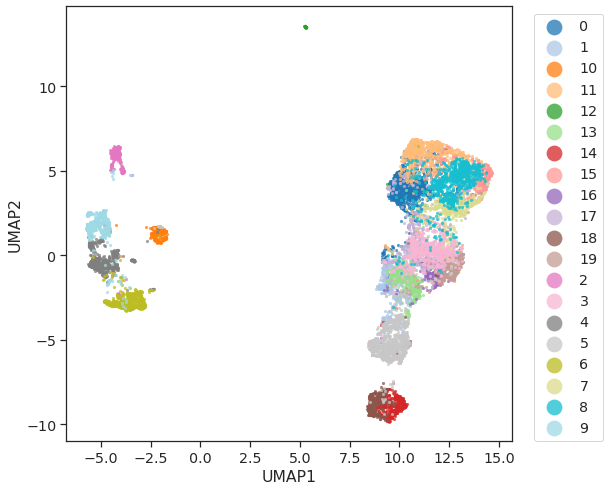

In [9]:
clustering.plot_sample_clusters(sample_id="Corrected_165-09",
                                method="UMAP",
                                include_legend=True,
                                legend_kwargs={"bbox_to_anchor": (1.22, 1.0),
                                               "markerscale": 5})

The function `clustered_heatmap` provides a heatmap with the axis labels clustered using hierarchical clustering. This function in fact makes use of the Seaborn library and `clustermap`, therefore we can pass any additional keyword arguments available for this function: https://seaborn.pydata.org/generated/seaborn.clustermap.html

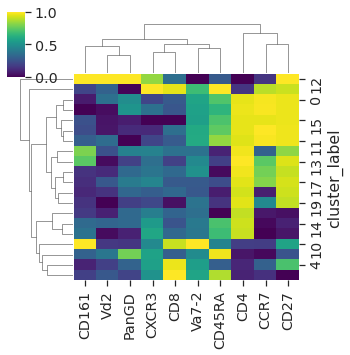

In [10]:
clustering.clustered_heatmap(features=['CXCR3', 'CD161', 'CCR7', 'Va7-2',
                                       'CD8', 'Vd2', 'CD45RA', 'PanGD', 
                                       'CD4', 'CD27'],
                             sample_id="Corrected_165-09",
                             figsize=(5, 5),
                             cmap="viridis",
                             standard_scale=1,
                             vmin=0, vmax=1)

<h2>Meta clustering</h2>

With each individual sample clustered we can now match clusters between samples by clustering their centroids. We do this using the `meta_cluster` function and for this we will pass the `consensus_metacluster` function. We have specified to generate centroids using the median of each channel and will take the consensus of Ward's hierarchical clustering with 100 rounds of resampling.

In [27]:
clustering.meta_cluster(consensus_metacluster,
                        summary_method="median",
                        cluster_class=AgglomerativeClustering(linkage="ward"),
                        scale_method=None,
                        smallest_cluster_n=10,
                        largest_cluster_n=20,
                        n_resamples=100)

----- Consensus meta-clustering ------


  0%|          | 0/10 [00:00<?, ?it/s]

Clustering performance...
Silhouette coefficient: 0.2902675912897558
Calinski-Harabasz index: 101.59823537850792
Davies-Bouldin index: 1.0479917866699926


If we call `plot_meta_clusters` the individual cluster centroids are plotted as a bubble plot and they are coloured by their meta cluster ownership. The size of the data point represents the percentage of cells within that centroid as a fraction of the total cells in the sample it originated from.

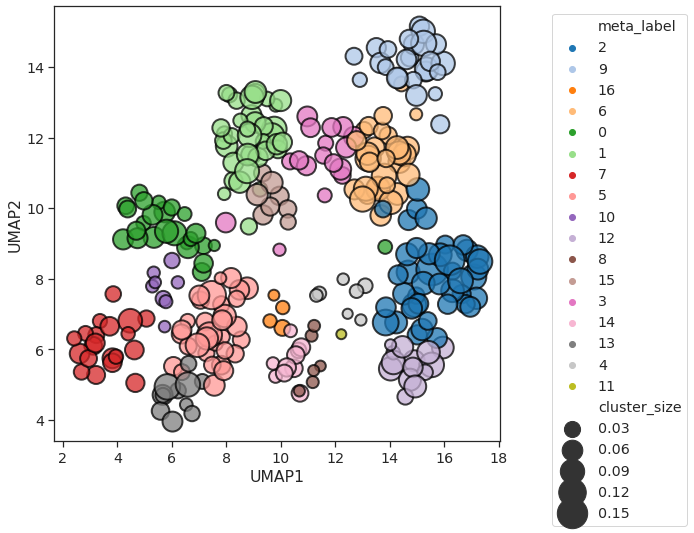

In [28]:
clustering.plot_meta_clusters(dim_reduction_kwargs={"n_neighbors": 50,
                                                    "min_dist": 1})
plt.savefig("figures/FlowSOM/meta_umap.png", dpi=300, facecolor="white", bbox_inches="tight")

I haven't associated the corrected data to subject's in our database, but the subject ID is embedded in the sample ID in this case, so I'm just going to manufacture the subject column from the sample ID.

In [29]:
clustering.data["subject"] = clustering.data["sample_id"].apply(lambda x: x.replace("Corrected_", ""))

In `plot_meta_clusters` we can specify any column from `Clustering.data` as a `colour_label` to colour our centroids. In the plot below we see a nice distribution of all our subjects across the many meta clusters identified.

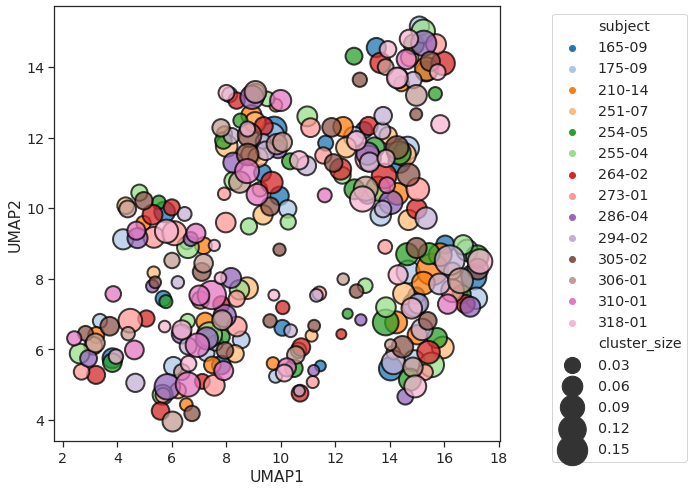

In [30]:
clustering.plot_meta_clusters(dim_reduction_kwargs={"n_neighbors": 50,
                                                    "min_dist": 1},
                              colour_label="subject")
plt.savefig("figures/FlowSOM/meta_umap_subject.png", dpi=300, facecolor="white", bbox_inches="tight")

Calling `clustered_heatmap` without specifying `sample_id` and with "meta_label" populated in `Clustering.data` will result in the meta labels being displayed in a clustered heatmap.

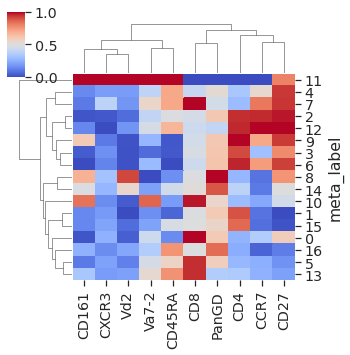

In [31]:
clustering.clustered_heatmap(features=['CXCR3', 'CD161', 'CCR7', 'Va7-2',
                                       'CD8', 'Vd2', 'CD45RA', 'PanGD', 
                                       'CD4', 'CD27'],
                             figsize=(5, 5),
                             cmap="coolwarm",
                             standard_scale=1,
                             yticklabels=True)

We have an anomaly in meta cluster 11. It appears to express high values for many of our channels and is likely concentrated with one subject and is an outlier. We can access the `data` attribute and subset on the "meta_label" to take a look:

In [32]:
clustering.data[clustering.data.meta_label == 11]

original_index     FSC-A     FSC-H     SSC-A     SSC-W     CXCR3  \
69990             479  0.884853  0.851558  0.776390  0.887638  0.494668   
69991            1403  0.864492  0.847406  0.739140  0.862380  0.522736   
69992            4388  0.874292  0.854647  0.743268  0.859323  0.492934   
69993            6336  0.869345  0.850833  0.755971  0.862567  0.483906   
69994            6351  0.867933  0.847341  0.765926  0.875266  0.577879   
69995            7006  0.868235  0.852279  0.758613  0.861180  0.589608   
69996            7064  0.851960  0.828862  0.770149  0.861266  0.506129   
69997            7533  0.864115  0.838770  0.789875  0.865408  0.589878   
69998            9646  0.886304  0.866389  0.785835  0.863855  0.576043   

          CD161      CCR7     Va7-2       CD8  ...    CD45RA     PanGD  \
69990  0.552892  0.400002  0.468606  0.094149  ...  0.778520 -0.255389   
69991  0.668665  0.118603  0.636204 -0.174420  ...  0.830474 -0.377819   
69992  0.489553  0.353440  0.633107 -0.078051  ...  0.793187 -0.338022   
69993  0.446010  0.471640  0.579073  0.093475  ...  0.764783 -0.161708   
69994  0.645755  0.436900  0.682427 -0.223760  ...  0.901906 -0.451526   
69995  0.653353  0.135654  0.714614 -0.266467  ...  0.894171 -0.432929   
69996  0.595299  0.225922  0.609014 -0.187945  ...  0.831236 -0.352359   
69997  0.603302 -0.041931  0.704995 -0.285501  ...  0.891936 -0.386455   
69998  0.630802  0.154103  0.630764 -0.096020  ...  0.875942 -0.437894   

            CD4      CD27   population_label         sample_id subject_id  \
69990  0.346022  0.483250  XGB__Unclassified  Corrected_264-02       None   
69991  0.268200  0.492384    XGB__MAIT cells  Corrected_264-02       None   
69992  0.376835  0.523782    XGB__MAIT cells  Corrected_264-02       None   
69993  0.096562  0.541523    XGB__MAIT cells  Corrected_264-02       None   
69994 -0.181372  0.506162    XGB__MAIT cells  Corrected_264-02       None   
69995 -0.072128  0.475155    XGB__MAIT cells  Corrected_264-02       None   
69996 -0.104893  0.440453    XGB__MAIT cells  Corrected_264-02       None   
69997 -0.074835  0.533565    XGB__MAIT cells  Corrected_264-02       None   
69998 -0.184223  0.482618    XGB__MAIT cells  Corrected_264-02       None   

      cluster_label subject meta_label  
69990            20  264-02         11  
69991            20  264-02         11  
69992            20  264-02         11  
69993            20  264-02         11  
69994            20  264-02         11  
69995            20  264-02         11  
69996            20  264-02         11  
69997            20  264-02         11  
69998            20  264-02         11  

[9 rows x 21 columns]

We see that this cluster consists of 9 events from one sample, therefore we can drop this as outliers.

In [33]:
clustering.data = clustering.data[clustering.data.meta_label != 11].copy()

Let's reproduce our plots:

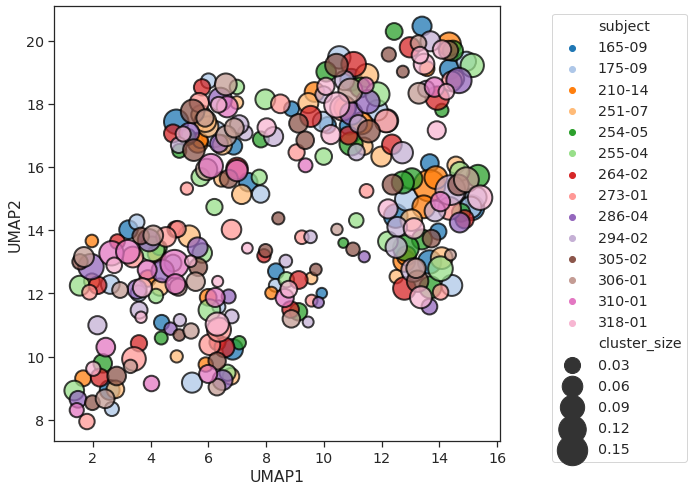

In [34]:
clustering.plot_meta_clusters(dim_reduction_kwargs={"n_neighbors": 50,
                                                    "min_dist": 1},
                              colour_label="subject")
plt.savefig("figures/FlowSOM/meta_umap_subject.png", dpi=300, facecolor="white", bbox_inches="tight")

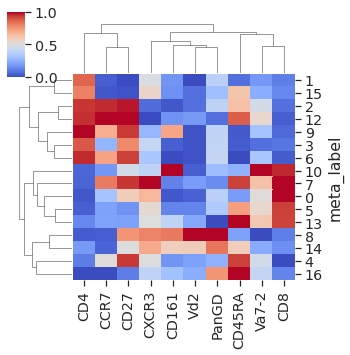

In [35]:
clustering.clustered_heatmap(features=['CXCR3', 'CD161', 'CCR7', 'Va7-2',
                                       'CD8', 'Vd2', 'CD45RA', 'PanGD', 
                                       'CD4', 'CD27'],
                             figsize=(5, 5),
                             cmap="coolwarm",
                             standard_scale=1,
                             yticklabels=True)

Now that our heatmap has cluster 11 removed, we can rename our meta clusters to something more recognisable based on the expression profile of each cluster. We could go as far as identifying memory subsets of CD4$^{+}$ and CD8$^{+}$ T cells, given the staining panel we have. For this exercise though we will just name them with an index.

To rename meta clusters we use the `rename_meta_clusters` function:

In [42]:
clustering.rename_meta_clusters({1: "CD4+ T cells (1)",
                                 14:"CD4+ T cells (2)",
                                 2: "CD4+ T cells (3)",
                                 12:"CD4+ T cells (4)",
                                 9: "CD4+ T cells (5)",
                                 3: "CD4+ T cells (6)",
                                 6: "CD4+ T cells (7)",
                                 15:"CD4+ T cells (8)",
                                 10:"MAIT cells",
                                 7: "CD8+ T cells (1)",
                                 0: "CD8+ T cells (2)",
                                 5: "CD8+ T cells (3)",
                                 13:"CD8+ T cells (4)",
                                 0: "CD8+ T cells (2)",
                                 8: "Vδ2+ γδ T cells",
                                 14:"Vδ2+ γδ T cells",
                                 4: "CD4- CD8- T cells",
                                 16:"CD4- CD8- T cells"})

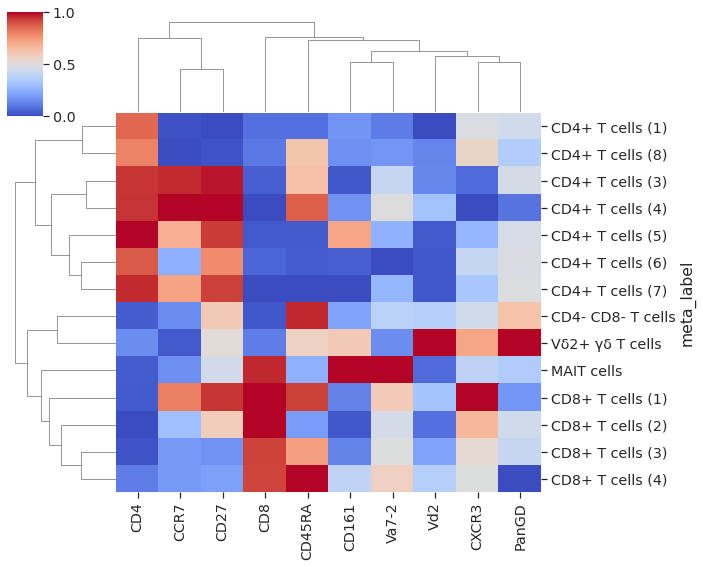

In [43]:
clustering.clustered_heatmap(features=['CXCR3', 'CD161', 'CCR7', 'Va7-2',
                                       'CD8', 'Vd2', 'CD45RA', 'PanGD', 
                                       'CD4', 'CD27'],
                             figsize=(10, 8),
                             cmap="coolwarm",
                             standard_scale=1,
                             yticklabels=True)
plt.savefig("figures/FlowSOM/meta_heatmap.png", dpi=300, facecolor="white", bbox_inches="tight")

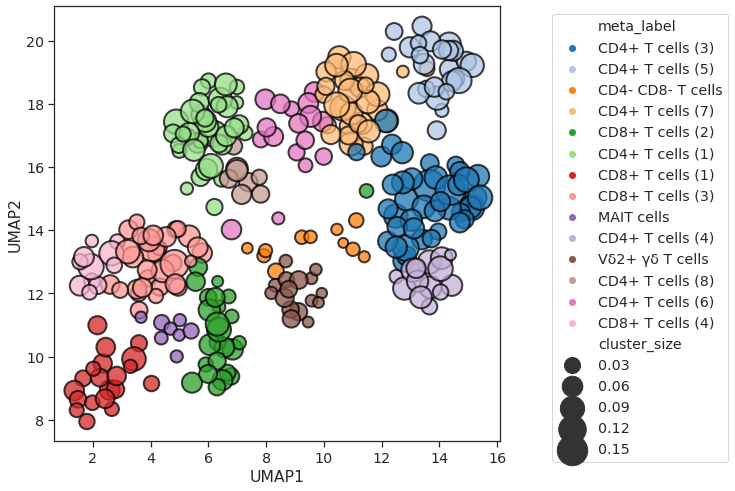

In [44]:
clustering.plot_meta_clusters(dim_reduction_kwargs={"n_neighbors": 50,
                                                    "min_dist": 1})
plt.savefig("figures/FlowSOM/meta_umap.png", dpi=300, facecolor="white", bbox_inches="tight")

To save our results we call the `save` method on our `Clustering` object. This will iterate over the samples in `Clustering.data`, then iterate over each cluster in that sample and generate a `Population` for that cluster. We can specify `population_var` as variable in `data` that will serve as the population name. By default the value is "meta_label" meaning each `Population` will be named according the meta label it has been assigned to; this is desirable since we want to be able to identify the same populations between samples.

In [45]:
clustering.save()

  0%|          | 0/14 [00:00<?, ?it/s]

<h2>Comparison to manual gating</h2>

In [7]:
auto_results = exp.population_statistics()
manual = pd.read_csv("manual_gates1.csv")

In [8]:
def auto_vs_manual(auto_results: pd.DataFrame,
                   manual: pd.DataFrame,
                   auto_population_name: str,
                   manual_population_name: str):
    sample_n = (auto_results[auto_results.population_name.str.contains("FlowSOM")]
                .groupby("sample_id")
                .n.sum())
    sample_n.name = "sample_n"
    auto = auto_results[auto_results.population_name.str.contains(auto_population_name)].copy()
    auto = auto.groupby(["sample_id"]).n.sum()
    auto = sample_n.reset_index().merge(auto.reset_index(), on="sample_id")
    auto["Auto"] = auto["n"]/auto["sample_n"]
    auto["sample_id"] = auto["sample_id"].apply(lambda x: x.replace("Corrected_", ""))
    manual["Manual"] = manual[manual_population_name]/manual["Live single CD3+ cells"]
    stats = manual.merge(auto, on="sample_id", how="outer")
    stats.fillna(0, inplace=True)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(stats.Auto.values*100,
               stats.Manual.values*100,
               edgecolor="black",
               color="#4e7abf",
               s=120,
               linewidth=2,
               zorder=1)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", zorder=0)
    axis_lower_lim = np.min([np.min(ax.get_xlim()),
                             np.min(ax.get_ylim())])
    axis_upper_lim = np.max([np.max(ax.get_xlim()),
                             np.max(ax.get_ylim())])
    ax.set_xlim((axis_lower_lim, axis_upper_lim))
    ax.set_ylim((axis_lower_lim, axis_upper_lim))
    ax.locator_params(axis='y', nbins=6)
    ax.locator_params(axis='x', nbins=6)
    ax.set_xlabel("Autonomous gates")
    ax.set_ylabel("Manual gates")
    return ax, stats

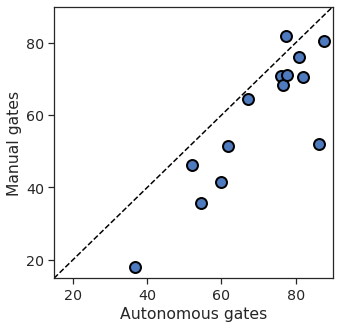

In [9]:
ax, stats = auto_vs_manual(auto_results, manual, "FlowSOM_CD4+", "CD4+ CD8- T cells")
plt.savefig("figures/FlowSOM/cd4.png", facecolor="white", bbox_inches="tight", dpi=300)
plt.show()

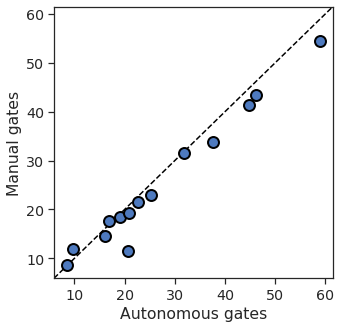

In [10]:
ax, stats = auto_vs_manual(auto_results, manual, "FlowSOM_CD8+", "CD4- CD8+ T cells")
plt.savefig("figures/FlowSOM/cd8.png", facecolor="white", bbox_inches="tight", dpi=300)
plt.show()

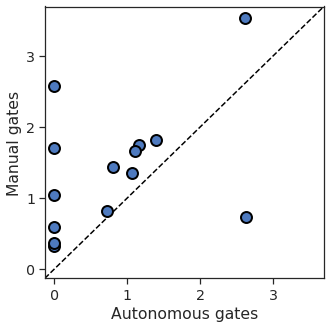

In [11]:
ax, stats = auto_vs_manual(auto_results, manual, "FlowSOM_MAIT", "MAIT cells")
plt.savefig("figures/FlowSOM/MAITs.png", facecolor="white", bbox_inches="tight", dpi=300)
plt.show()

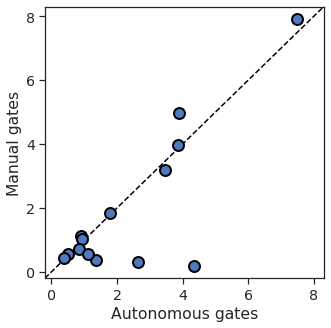

In [12]:
ax, stats = auto_vs_manual(auto_results, manual, "FlowSOM_Vδ2+", "Vd2+ GDTs")
plt.savefig("figures/FlowSOM/GDTs.png", facecolor="white", bbox_inches="tight", dpi=300)
plt.show()